# Galaxy Cluster Dark Matter Analysis: ACO 2670

This notebook analyzes the ACO 2670 galaxy cluster using SDSS data to estimate virial mass and mass-to-light ratios. See the accompanying PDF report for detailed methodology and theoretical background.

## Data Retrieval

To analyze the ACO 2670 galaxy cluster, photometric and spectroscopic data were retrieved from the Sloan Digital Sky Survey (SDSS) Data Release 18 (DR18). The dataset included the positions, magnitudes, extinction corrections, and redshifts of galaxies in a 2 Mpc region centered on the cluster. The SQL query used for data retrieval applied spatial and redshift constraints to ensure that the sample included only galaxies near the cluster while filtering out foreground and background objects. The initial member selection used a 3σ clipping method, retaining galaxies within three standard deviations of the mean redshift.

https://skyserver.sdss.org/dr18/SearchTools/sql

```sql
SELECT 
    p.objID,               
    p.ra,                  
    p.dec,                 
    p.r,                   
    p.psfMagErr_r AS rErr, 
    p.extinction_r,        
    s.z,                   
    s.zErr                 
FROM 
    PhotoObj AS p          
JOIN 
    SpecObj AS s           
ON 
    p.objID = s.bestObjID  
WHERE 
    p.ra BETWEEN 358.19 AND 358.89  
    AND p.dec BETWEEN -10.76 AND -10.06  
    AND s.z BETWEEN 0.024 AND 0.124  
    AND s.class = 'GALAXY'  
    AND p.type = 3  -- 3 corresponds to 'GALAXY' in PhotoObj.type
    AND s.z IS NOT NULL  
    AND s.class IS NOT NULL

## Data Import and Initial Setup

In [1]:
# Step 1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Load the data from the CSV file
member_galaxies = pd.read_csv('data/cluster_data.csv', comment='#')

# Extract relevant columns
ra = member_galaxies["ra"]  # Right Ascension
dec = member_galaxies["dec"]  # Declination
redshift = member_galaxies["z"]  # Redshift
redshift_err = member_galaxies["zErr"]  # Redshift errors

# Print the number of galaxies
print(f"Number of member galaxies: {len(member_galaxies)}")
# Display the first few rows
print(member_galaxies.head())

# Define some constants
c = 299792.458  # km/s (speed of light)
H0 = 67.8  # km/s/Mpc
H0_uncertainty=0.46

Number of member galaxies: 126
                 objID          ra        dec         r      rErr  \
0  1237652900210606324  358.553238 -10.320936  16.56860  0.019683   
1  1237652946914443500  358.571981 -10.499275  17.53928  0.023191   
2  1237652900210606358  358.575300 -10.268084  16.54139  0.019187   
3  1237652900210606361  358.578422 -10.200501  16.67887  0.019231   
4  1237652900210671686  358.619591 -10.154043  16.68105  0.029733   

   extinction_r         z      zErr  
0      0.104327  0.082485  0.000013  
1      0.084952  0.073160  0.000028  
2      0.098072  0.076726  0.000017  
3      0.092227  0.079812  0.000018  
4      0.084221  0.077471  0.000018  


## Spatial Distribution Analysis

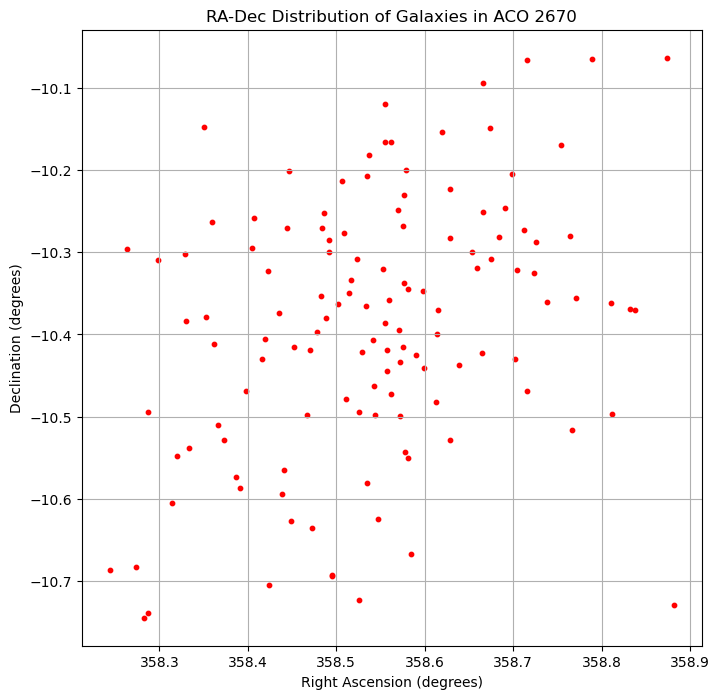

In [2]:
# Step 2

# Create the plot
plt.figure(figsize=(8, 8))
plt.scatter(member_galaxies["ra"], member_galaxies["dec"], color='red', s=10)

# Formatting
plt.xlabel("Right Ascension (degrees)")
plt.ylabel("Declination (degrees)")
plt.title("RA-Dec Distribution of Galaxies in ACO 2670")
plt.grid(True)

# Show the plot
plt.show()

## Cluster Center Determination

In [3]:
# Step 3

def compute_cluster_center(member_galaxies):
    """
    Compute the weighted mean Right Ascension (RA) and Declination (Dec)
    using inverse squared r-band magnitude errors as weights,
    with proper uncertainty calculations.
    
    Parameters:
        member_galaxies (DataFrame): Data containing member galaxies.
    
    Returns:
        tuple: (weighted_ra, weighted_dec, ra_uncertainty, dec_uncertainty)
    """
    # Calculate weights based on inverse squared errors
    weights = 1 / (member_galaxies['rErr'] ** 2)
    
    # Calculate weighted means
    weighted_ra = np.average(member_galaxies['ra'], weights=weights)
    weighted_dec = np.average(member_galaxies['dec'], weights=weights)
    
    # This accounts for both measurement errors and scatter in the data
    N = len(member_galaxies)
    
    # Calculate weighted variance (accounting for scatter in the data)
    weighted_var_ra = np.sum(weights * (member_galaxies['ra'] - weighted_ra)**2) / (np.sum(weights) * (N-1)/N)
    weighted_var_dec = np.sum(weights * (member_galaxies['dec'] - weighted_dec)**2) / (np.sum(weights) * (N-1)/N)
    
    # Standard error of the weighted mean
    ra_uncertainty = np.sqrt(weighted_var_ra / np.sum(weights))
    dec_uncertainty = np.sqrt(weighted_var_dec / np.sum(weights))
    
    print(f"Weighted Mean RA: {weighted_ra:.4f} ± {ra_uncertainty:.4f} degrees")
    print(f"Weighted Mean Dec: {weighted_dec:.4f} ± {dec_uncertainty:.4f} degrees")
    
    return weighted_ra, weighted_dec, ra_uncertainty, dec_uncertainty

weighted_ra, weighted_dec, ra_uncertainty, dec_uncertainty = compute_cluster_center(member_galaxies)

Weighted Mean RA: 358.5492 ± 0.0003 degrees
Weighted Mean Dec: -10.3909 ± 0.0003 degrees


## Redshift Distribution and Model Selection

Cluster Redshift: 0.076150 ± 0.003352
BIC (Single Gaussian): -786.14
BIC (GMM): -933.80


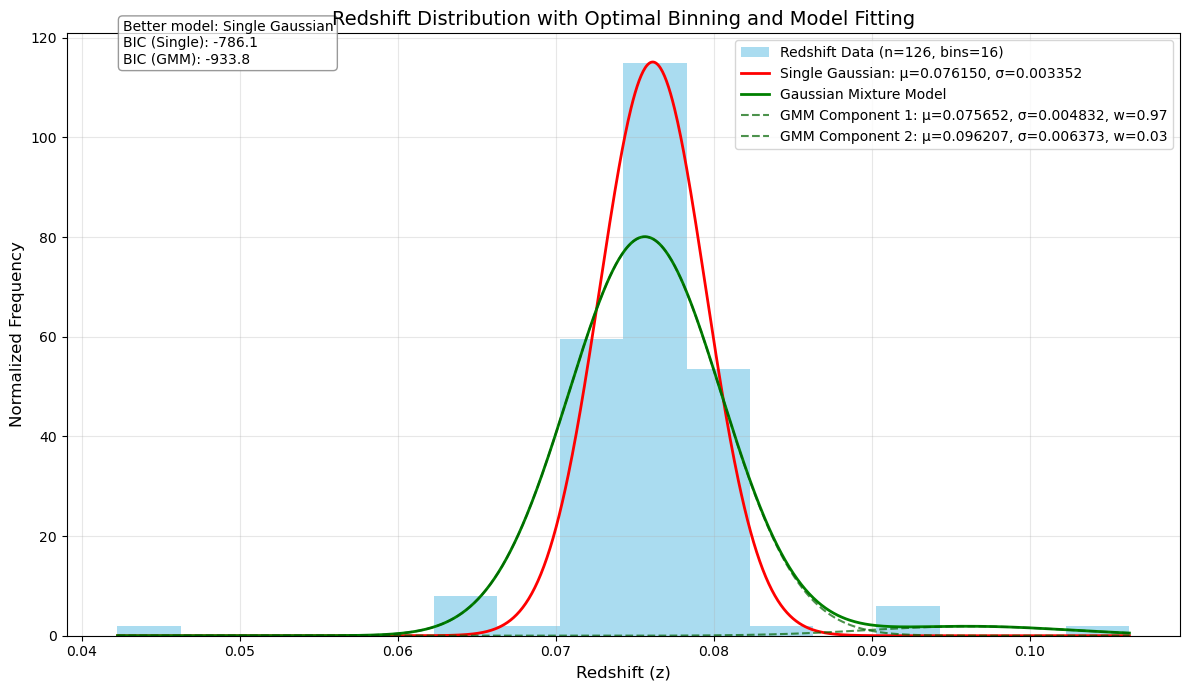

In [4]:
from scipy.optimize import curve_fit
from sklearn.mixture import GaussianMixture

# Define Gaussian function
def gaussian(x, amp, mean, std):
    return amp * np.exp(-0.5 * ((x - mean) / std) ** 2)

def compute_redshift_distribution(member_galaxies, weight_threshold=0.2):
    """
    Compute the redshift distribution using both a weighted single Gaussian fit 
    and a Gaussian Mixture Model (GMM) to determine the best model.
    
    Parameters:
        member_galaxies (DataFrame): Data containing redshifts and redshift errors.
        weight_threshold (float): Minimum weight threshold for GMM components
    
    Returns:
        tuple: (cluster_z, cluster_z_std, bin_edges, popt, gmm, better_model, bic_single, bic_gmm) 
    """
    redshifts = member_galaxies['z'].values
    z_errors = member_galaxies['zErr'].values
    
    # Optimal binning (Freedman-Diaconis Rule)
    q75, q25 = np.percentile(redshifts, [75, 25])
    iqr = q75 - q25
    bin_width = 2 * iqr / (len(redshifts))**(1/3)
    bin_width = max(bin_width, 3.5 * np.std(redshifts) / (len(redshifts))**(1/3))
    n_bins = max(int(np.ceil((redshifts.max() - redshifts.min()) / bin_width)), 10)
    
    # Create weighted histogram
    hist, bin_edges = np.histogram(redshifts, bins=n_bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Calculate weights for each galaxy based on redshift errors
    weights = 1 / (z_errors ** 2)
    
    # Weighted mean and standard deviation for initial guess
    weighted_mean = np.average(redshifts, weights=weights)
    weighted_std = np.sqrt(np.average((redshifts-weighted_mean)**2, weights=weights))
    
    # Fit weighted Gaussian to binned data
    hist_errors = np.sqrt(hist)  # Approximate error for each bin
    hist_errors[hist_errors == 0] = 1  # Avoid division by zero
    popt, pcov = curve_fit(gaussian, bin_centers, hist, 
                          p0=[max(hist), weighted_mean, weighted_std],
                          sigma=1/hist_errors)
    mean_z, std_z = popt[1], popt[2]
    
    # Fit Gaussian Mixture Model (GMM)
    X = redshifts.reshape(-1, 1)
    gmm = GaussianMixture(n_components=2, random_state=42).fit(X)
    
    # Get GMM component weights
    gmm_weights = gmm.weights_

    # PROPER BIC calculation for single Gaussian
    log_likelihood_single = np.sum(np.log(gaussian(redshifts, *popt)))
    bic_single = 3 * np.log(len(redshifts)) - 2 * log_likelihood_single  # 3 params: amp, mean, std
    
    # Get GMM BIC directly
    bic_gmm = gmm.bic(X)

    # Determine best model
    if bic_gmm < bic_single and np.all(gmm_weights > weight_threshold):
        better_model = "Mixture of Gaussians"
        main_component = np.argmax(gmm_weights)
        cluster_z, cluster_z_std = gmm.means_[main_component, 0], np.sqrt(gmm.covariances_[main_component, 0, 0])
    else:
        better_model = "Single Gaussian"
        cluster_z, cluster_z_std = mean_z, std_z

    print(f"Cluster Redshift: {cluster_z:.6f} ± {cluster_z_std:.6f}")
    print(f"BIC (Single Gaussian): {bic_single:.2f}")
    print(f"BIC (GMM): {bic_gmm:.2f}")
    
    return cluster_z, cluster_z_std, bin_edges, popt, gmm, better_model, bic_single, bic_gmm

def plot_redshift_distribution(redshifts, bin_edges, popt, gmm, better_model, 
                             cluster_z, cluster_z_std, bic_single, bic_gmm):
    """
    Plot the redshift distribution with model fits.
    
    Parameters:
        redshifts (array): Array of redshift values
        bin_edges (array): Bin edges for histogram
        popt (array): Parameters for single Gaussian fit
        gmm (GaussianMixture): Fitted GMM model
        better_model (str): Which model was selected
        cluster_z (float): Cluster redshift
        cluster_z_std (float): Redshift standard deviation
        bic_single (float): BIC for single Gaussian
        bic_gmm (float): BIC for GMM
    """
    plt.figure(figsize=(12, 7))
    
    # Plot histogram
    plt.hist(redshifts, bins=bin_edges, density=True, color='skyblue', 
             alpha=0.7, label=f'Redshift Data (n={len(redshifts)}, bins={len(bin_edges)-1})')

    # Plot single Gaussian fit
    x = np.linspace(min(redshifts), max(redshifts), 1000)
    plt.plot(x, gaussian(x, *popt), color='red', linewidth=2, 
             label=f'Single Gaussian: μ={cluster_z:.6f}, σ={cluster_z_std:.6f}')

    # Plot GMM
    x_reshaped = x.reshape(-1, 1)
    log_density = gmm.score_samples(x_reshaped)
    density = np.exp(log_density)
    plt.plot(x, density, color='green', linewidth=2, 
             label='Gaussian Mixture Model')

    # Plot individual GMM components
    for i in range(gmm.n_components):
        mean = gmm.means_[i, 0]
        std = np.sqrt(gmm.covariances_[i, 0, 0])
        weight = gmm.weights_[i]
        component = weight * stats.norm.pdf(x, mean, std)
        plt.plot(x, component, '--', color='darkgreen', alpha=0.7,
                 label=f'GMM Component {i+1}: μ={mean:.6f}, σ={std:.6f}, w={weight:.2f}')

    # Add model comparison annotation
    plt.annotate(f'Better model: {better_model}\nBIC (Single): {bic_single:.1f}\nBIC (GMM): {bic_gmm:.1f}',
                 xy=(0.05, 0.95), xycoords='axes fraction',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

    plt.xlabel('Redshift (z)', fontsize=12)
    plt.ylabel('Normalized Frequency', fontsize=12)
    plt.title('Redshift Distribution with Optimal Binning and Model Fitting', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

results = compute_redshift_distribution(member_galaxies)
cluster_z, cluster_z_std, bin_edges, popt, gmm, better_model, bic_single, bic_gmm = results

# Plot
plot_redshift_distribution(member_galaxies['z'].values, bin_edges, popt, gmm, 
                         better_model, cluster_z, cluster_z_std, bic_single, bic_gmm)

## Distance Calculations

In [5]:
# Step 5: Calculate distance to cluster
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=H0, Om0=0.3089)

def compute_cluster_distance(cluster_z, z_uncertainty):
    """
    Compute the cluster's distance using redshift and the FlatLambdaCDM model,
    including uncertainty calculations.
    
    Parameters:
        cluster_z (float): Cluster redshift
        z_uncertainty (float): Uncertainty in the redshift
        H0 (float): Hubble constant in km/s/Mpc
        H0_uncertainty (float): Uncertainty in Hubble constant
    
    Returns:
        tuple: (distance_to_cluster, distance_uncertainty, v_rec, v_rec_uncertainty)
    """
    
    # Relativistic velocity calculation
    v_rec = c * ((1 + cluster_z)**2 - 1) / ((1 + cluster_z)**2 + 1)
    
    # Cosmological distance calculation
    distance_to_cluster = cosmo.luminosity_distance(cluster_z).value  # Mpc
    
    # Uncertainty calculations
    # For recession velocity (using partial derivatives for error propagation)
    dv_dz = c * 4 * (1 + cluster_z) / (((1 + cluster_z)**2 + 1)**2)
    v_rec_uncertainty = abs(dv_dz * z_uncertainty)
    
    # For distance uncertainty (approximate using small changes in z)
    delta_z = z_uncertainty / 10  # Small increment for numerical derivative
    distance_plus = cosmo.luminosity_distance(cluster_z + delta_z).value
    distance_minus = cosmo.luminosity_distance(cluster_z - delta_z).value
    distance_derivative = (distance_plus - distance_minus) / (2 * delta_z)
    distance_z_uncertainty = abs(distance_derivative * z_uncertainty)
    
    # Adding uncertainty due to H0
    # Distance scales inversely with H0: d ∝ 1/H0
    distance_H0_uncertainty = distance_to_cluster * (H0_uncertainty / H0)
    
    # Total uncertainty (adding in quadrature)
    distance_uncertainty = np.sqrt(distance_z_uncertainty**2 + distance_H0_uncertainty**2)
    
    print(f"Recessional Velocity: {v_rec:.2f} ± {v_rec_uncertainty:.2f} km/s")
    print(f"Distance to Cluster: {distance_to_cluster:.2f} ± {distance_uncertainty:.2f} Mpc")
    
    return distance_to_cluster, distance_uncertainty, v_rec, v_rec_uncertainty

# Assuming you have cluster_z and z_uncertainty from your Step 4 Gaussian fit
distance_to_cluster, distance_uncertainty, v_rec, v_rec_uncertainty = compute_cluster_distance(cluster_z, cluster_z_std)

Recessional Velocity: 21962.31 ± 928.65 km/s
Distance to Cluster: 355.87 ± 16.66 Mpc


## Projected Distance Computation

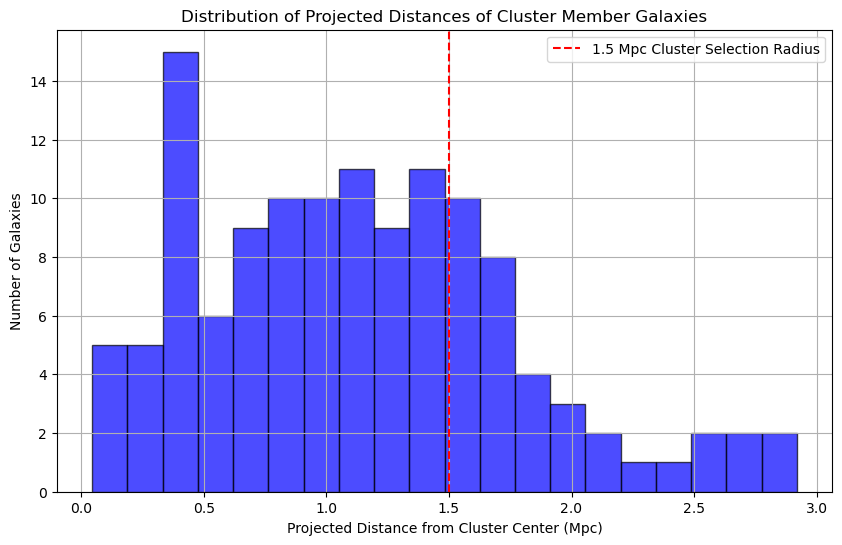

In [6]:
# Step 6

def compute_projected_distance(member_galaxies, cluster_ra, cluster_dec, distance_to_cluster):
    """
    Compute projected distances from cluster center in Mpc.

    Parameters:
        member_galaxies (DataFrame): Contains RA, Dec values of galaxies.
        cluster_ra (float): Cluster right ascension (degrees).
        cluster_dec (float): Cluster declination (degrees).
        distance_to_cluster (float): Cluster distance in Mpc.

    Returns:
        Updated DataFrame with 'proj_dist' column.
    """
    # Convert degrees to radians
    ra_rad = np.radians(member_galaxies['ra'])
    dec_rad = np.radians(member_galaxies['dec'])
    cluster_ra_rad = np.radians(cluster_ra)
    cluster_dec_rad = np.radians(cluster_dec)

    # Compute angular separation
    delta_ra = (ra_rad - cluster_ra_rad) * np.cos(cluster_dec_rad)
    delta_dec = dec_rad - cluster_dec_rad
    theta_rad = np.sqrt(delta_ra**2 + delta_dec**2)  # Angular separation in radians

    # Convert to projected physical distances
    projected_distance = distance_to_cluster * theta_rad  # Convert to Mpc

    # Add projected distances to DataFrame
    member_galaxies['proj_dist'] = projected_distance

    return member_galaxies

# Recompute projected distances
member_galaxies = compute_projected_distance(member_galaxies, weighted_ra, weighted_dec, distance_to_cluster)

# Step 6: Plot the distribution of projected distances
plt.figure(figsize=(10, 6))
plt.hist(member_galaxies['proj_dist'], bins=20, color='blue', alpha=0.7, edgecolor='black')
plt.axvline(1.5, color='red', linestyle='dashed', label="1.5 Mpc Cluster Selection Radius")
plt.xlabel("Projected Distance from Cluster Center (Mpc)")
plt.ylabel("Number of Galaxies")
plt.title("Distribution of Projected Distances of Cluster Member Galaxies")
plt.legend()
plt.grid(True)
plt.show()

## Member Galaxy Selection

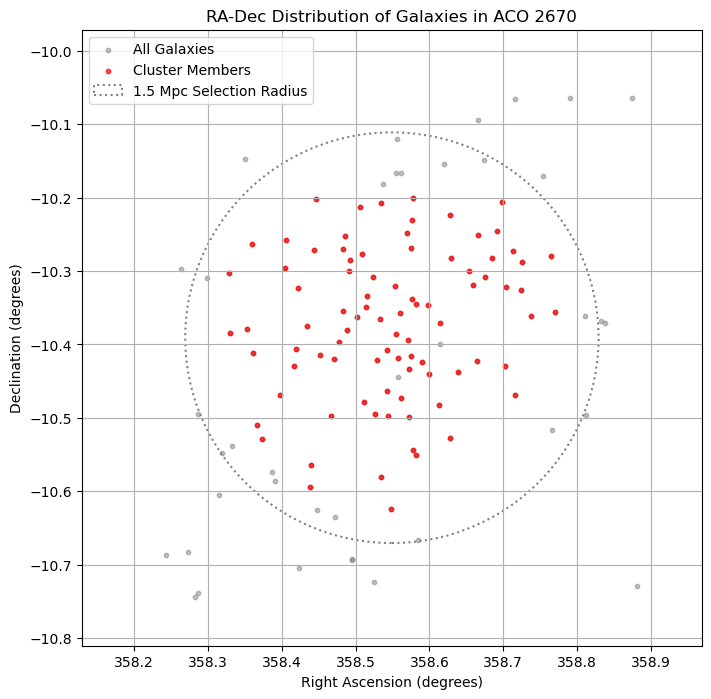

In [7]:
# Step 7: Select galaxies within radial distance of 1.5 Mpc and ±3σ of redshift
from matplotlib.patches import Circle

# Use compute_projected_distance function from Step 6 to get distances
df_copy = compute_projected_distance(member_galaxies.copy(), weighted_ra, weighted_dec, distance_to_cluster)

# Define redshift cuts based on current mean and std
z_min = cluster_z - 3 * cluster_z_std
z_max = cluster_z + 3 * cluster_z_std

# Select galaxies within 1.5 Mpc and ±3σ redshift range
member_galaxies = df_copy[(df_copy['proj_dist'] <= 1.5) & 
                          (df_copy['z'] >= z_min) & 
                          (df_copy['z'] <= z_max)].copy()

# Convert 1.5 Mpc to angular size (degrees)
angular_diameter_distance = cosmo.angular_diameter_distance(cluster_z).value  # Mpc
theta_radius = (1.5 / angular_diameter_distance) * (180 / np.pi)  # Convert to degrees

# Create the plot
plt.figure(figsize=(8, 8))

# Plot all galaxies (gray)
plt.scatter(df_copy['ra'], df_copy['dec'], color='gray', alpha=0.5, label="All Galaxies", s=10)

# Plot selected cluster members (red)
plt.scatter(member_galaxies["ra"], member_galaxies["dec"], color='red', alpha=0.7, label="Cluster Members", s=10)

# Add the 1.5 Mpc selection circle
circle = Circle((weighted_ra, weighted_dec), theta_radius, color='grey', 
                label="1.5 Mpc Selection Radius", fill=False, linestyle=':', linewidth=1.5)
plt.gca().add_patch(circle)

# Formatting
plt.xlabel("Right Ascension (degrees)")
plt.ylabel("Declination (degrees)")
plt.title("RA-Dec Distribution of Galaxies in ACO 2670")
plt.legend()
plt.grid(True)
plt.xlim(weighted_ra - 1.5 * theta_radius, weighted_ra + 1.5 * theta_radius)
plt.ylim(weighted_dec - 1.5 * theta_radius, weighted_dec + 1.5 * theta_radius)

# Show the plot
plt.show()

## Iterative Cluster Property Refinement

In [8]:
# Step 8

def refine_cluster_properties(member_galaxies, max_iterations=8, tolerance=1e-5):
    """
    Iteratively refine the cluster properties by re-running Steps 3 to 7 
    until convergence is reached (RA, Dec, Redshift, and Member Count stop changing). 
    The refinement process ensures a more accurate cluster center and redshift estimation.

    Parameters:
        member_galaxies (DataFrame): The initial set of member galaxies from Step 7.
        max_iterations (int, optional): Maximum number of iterations allowed. Default is 8.
        tolerance (float, optional): Convergence threshold for stopping criterion. Default is 1e-5.

    Returns:
        tuple:
            - final_ra (float): Weighted right ascension (RA) of the cluster in degrees.
            - final_dec (float): Weighted declination (Dec) of the cluster in degrees.
            - final_ra_unc (float): Uncertainty in the weighted RA.
            - final_dec_unc (float): Uncertainty in the weighted Dec.
            - final_z (float): Mean redshift of the cluster.
            - final_z_std (float): Redshift dispersion (1σ uncertainty).
            - final_count (int): Final number of member galaxies.
            - member_galaxies (DataFrame): Updated DataFrame of selected cluster member galaxies.
    
    Process:
        1. Compute the weighted mean RA and Dec (Step 3).
        2. Compute the redshift distribution and its uncertainty (Step 4).
        3. Compute the cluster distance from redshift (Step 5).
        4. Compute projected distances from the cluster center (Step 6).
        5. Apply selection criteria (1.5 Mpc radial limit & ±3σ redshift range) to refine membership (Step 7).
        6. Repeat until convergence is achieved or max_iterations is reached.

    Convergence Criterion:
        - The function stops iterating when the RA, Dec, Redshift, and the number of members
          no longer change beyond the specified tolerance.

    Notes:
        - The function accounts for uncertainties in RA and Dec.
        - If substructures exist in the cluster, the iterative refinement may take longer to converge.
        - The final member list is returned for use in further analysis (e.g., step 9).
    """
    
    prev_ra, prev_dec, prev_z, prev_count = None, None, None, None
    
    for iteration in range(max_iterations):
        print(f"\nIteration {iteration + 1}:")
        
        # Step 3: Compute weighted mean RA and Dec
        weighted_ra, weighted_dec, ra_uncertainty, dec_uncertainty = compute_cluster_center(member_galaxies)
        
        # Step 4: Compute redshift distribution
        # Adjust this line to match your function's actual return values
        redshift_results = compute_redshift_distribution(member_galaxies)
        cluster_z, cluster_z_std = redshift_results[0], redshift_results[1]
        
        # Step 5: Compute cluster distance (not strictly needed for Step 8, but useful)
        distance_results = compute_cluster_distance(cluster_z, cluster_z_std)
        distance_to_cluster = distance_results[0]
        
        # Step 6: Compute projected radial distances
        member_galaxies = compute_projected_distance(member_galaxies, weighted_ra, weighted_dec, distance_to_cluster)
        
        # Step 7: Re-select member galaxies using 1.5 Mpc and ±3σ redshift range
        z_min = cluster_z - 3 * cluster_z_std
        z_max = cluster_z + 3 * cluster_z_std
        member_galaxies = member_galaxies[(member_galaxies['proj_dist'] <= 1.5) & 
                                          (member_galaxies['z'] >= z_min) & 
                                          (member_galaxies['z'] <= z_max)].copy()
        
        member_count = len(member_galaxies)
        
        print(f"RA: {weighted_ra:.6f} ± {ra_uncertainty:.6f}, Dec: {weighted_dec:.6f} ± {dec_uncertainty:.6f}")
        print(f"Redshift: {cluster_z:.6f} ± {cluster_z_std:.6f}, Members: {member_count}")
        
        # Check for convergence
        if (prev_ra is not None and
            np.allclose([prev_ra, prev_dec, prev_z, prev_count], 
                        [weighted_ra, weighted_dec, cluster_z, member_count], 
                        atol=tolerance)):
            print("\nConvergence reached!")
            break
            
        # Update previous values for next iteration
        prev_ra, prev_dec, prev_z, prev_count = weighted_ra, weighted_dec, cluster_z, member_count
    
    return weighted_ra, weighted_dec, ra_uncertainty, dec_uncertainty, cluster_z, cluster_z_std, member_count, member_galaxies

# Run Step 8
final_ra, final_dec, final_ra_unc, final_dec_unc, final_z, final_z_std, final_count, member_galaxies = refine_cluster_properties(member_galaxies)

# Print final results
print("\nFinal Cluster Properties After Convergence:")
print(f"Weighted RA: {final_ra:.6f} ± {final_ra_unc:.6f} degrees")
print(f"Weighted Dec: {final_dec:.6f} ± {final_dec_unc:.6f} degrees")
print(f"Mean Redshift: {final_z:.6f} ± {final_z_std:.6f}")
print(f"Number of Member Galaxies: {final_count}")


Iteration 1:
Weighted Mean RA: 358.5450 ± 0.0003 degrees
Weighted Mean Dec: -10.3661 ± 0.0002 degrees
Cluster Redshift: 0.076683 ± 0.003273
BIC (Single Gaussian): -755.80
BIC (GMM): -734.32
Recessional Velocity: 22109.93 ± 906.47 km/s
Distance to Cluster: 358.49 ± 16.29 Mpc
RA: 358.544957 ± 0.000271, Dec: -10.366091 ± 0.000247
Redshift: 0.076683 ± 0.003273, Members: 84

Iteration 2:
Weighted Mean RA: 358.5494 ± 0.0003 degrees
Weighted Mean Dec: -10.3625 ± 0.0002 degrees
Cluster Redshift: 0.076514 ± 0.003379
BIC (Single Gaussian): -748.34
BIC (GMM): -716.63
Recessional Velocity: 22063.28 ± 935.78 km/s
Distance to Cluster: 357.67 ± 16.80 Mpc
RA: 358.549400 ± 0.000277, Dec: -10.362521 ± 0.000240
Redshift: 0.076514 ± 0.003379, Members: 84

Iteration 3:
Weighted Mean RA: 358.5494 ± 0.0003 degrees
Weighted Mean Dec: -10.3625 ± 0.0002 degrees
Cluster Redshift: 0.076514 ± 0.003379
BIC (Single Gaussian): -748.34
BIC (GMM): -716.63
Recessional Velocity: 22063.28 ± 935.78 km/s
Distance to Cluste

## Final Cluster Visualization

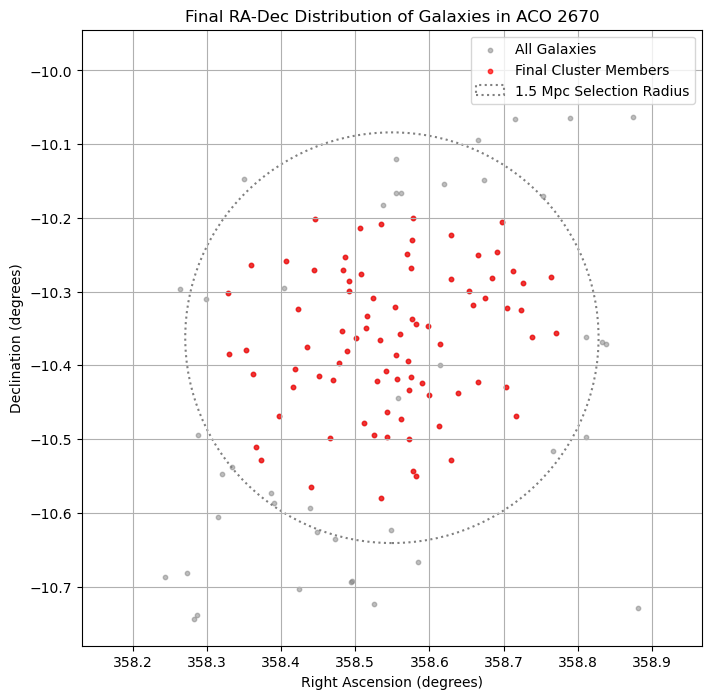

Cluster Redshift: 0.076514 ± 0.003379
BIC (Single Gaussian): -748.34
BIC (GMM): -716.63


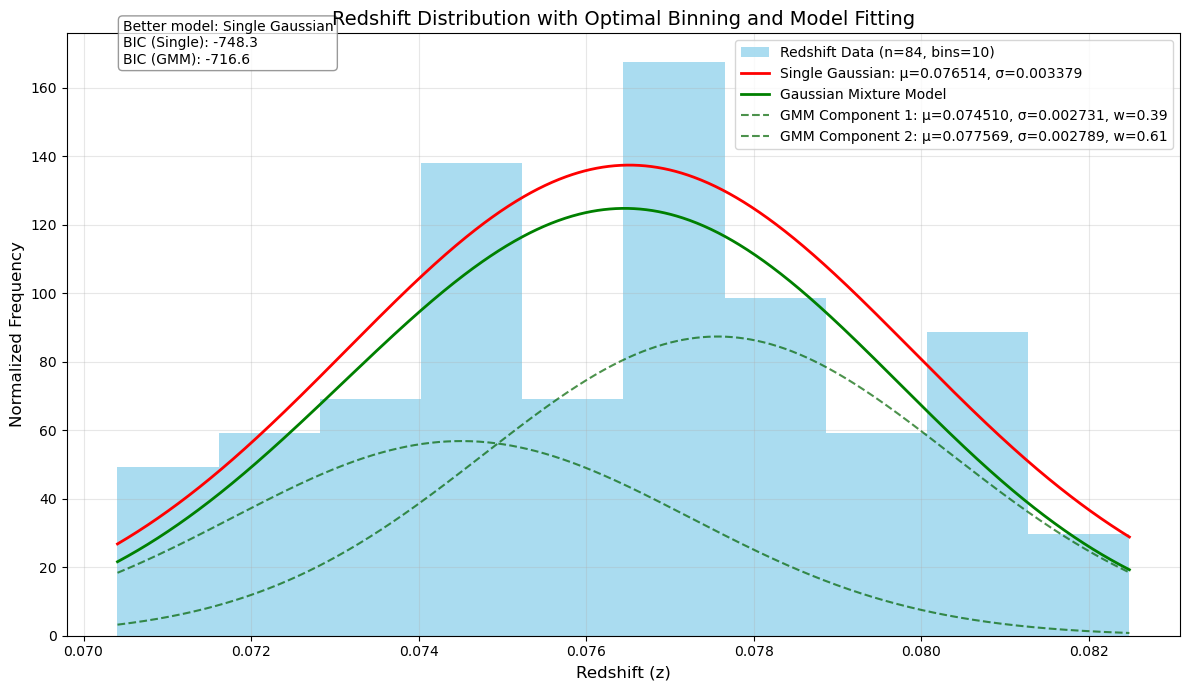

In [9]:
# Step 9.1: RA-Dec Plot with Final Cluster Members

# Convert 1.5 Mpc to angular size (degrees)
angular_diameter_distance = cosmo.angular_diameter_distance(final_z).value  # Mpc
theta_radius = (1.5 / angular_diameter_distance) * (180 / np.pi)  # Convert to degrees

# Create the plot
plt.figure(figsize=(8, 8))
plt.scatter(ra, dec, color='gray', alpha=0.5, label="All Galaxies", s=10)
plt.scatter(member_galaxies["ra"], member_galaxies["dec"], color='red', alpha=0.7, label="Final Cluster Members", s=10)

# Add the 1.5 Mpc selection circle
circle = Circle((final_ra, final_dec), theta_radius, color='grey', label="1.5 Mpc Selection Radius", fill=False, linestyle=':', linewidth=1.5)
plt.gca().add_patch(circle)

# Formatting
plt.xlabel("Right Ascension (degrees)")
plt.ylabel("Declination (degrees)")
plt.title("Final RA-Dec Distribution of Galaxies in ACO 2670")
plt.legend()
plt.grid(True)
plt.xlim(final_ra - 1.5 * theta_radius, final_ra + 1.5 * theta_radius)
plt.ylim(final_dec - 1.5 * theta_radius, final_dec + 1.5 * theta_radius)

# Show the plot
plt.show()


# Step 9.2: Final Redshift Distribution

results = compute_redshift_distribution(member_galaxies)
cluster_z, cluster_z_std, bin_edges, popt, gmm, better_model, bic_single, bic_gmm = results

# Plot
plot_redshift_distribution(member_galaxies['z'].values, bin_edges, popt, gmm, 
                         better_model, cluster_z, cluster_z_std, bic_single, bic_gmm)

## Photometric Analysis

          r  extinction_r        M_r   M_r_err
0  16.56860      0.104327 -21.292199  0.047682
1  17.53928      0.084952 -20.302145  0.049234
2  16.54139      0.098072 -21.313155  0.047479
3  16.67887      0.092227 -21.169829  0.047497
5  17.14178      0.087737 -20.702429  0.053364

Faintest Galaxy: -20.0367
Brightest Galaxy: -23.5709


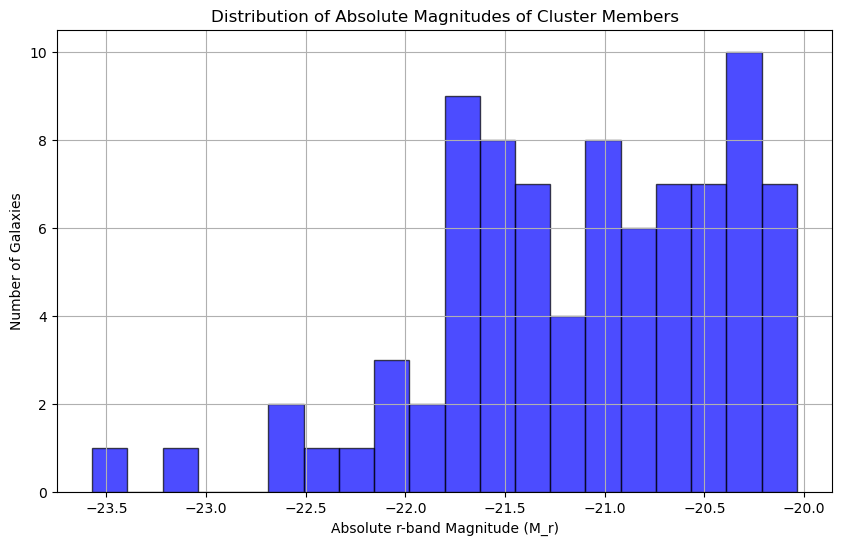

In [10]:
# Step 10

def compute_absolute_magnitude(member_galaxies, distance_to_cluster, distance_error):
    """
    Compute absolute r-band magnitudes and their corresponding errors.

    Parameters:
        member_galaxies (DataFrame): Contains r-band magnitudes and extinction values.
        distance_to_cluster (float): Cluster luminosity distance in Mpc.
        distance_error (float): Uncertainty in distance in Mpc.

    Returns:
        DataFrame: Updated with absolute magnitudes and errors.
    """
    # Extract necessary columns
    m_r = member_galaxies['r']  # Observed apparent magnitude
    A_r = member_galaxies['extinction_r']  # Extinction correction
    m_r_err = member_galaxies['rErr']  # Error in apparent magnitude

    # Convert distance to parsecs
    d_L_pc = distance_to_cluster * 1e6  # Convert Mpc to pc
    d_L_err_pc = distance_error * 1e6   # Convert Mpc error to pc

    # Compute absolute magnitudes
    M_r = m_r - A_r - 5 * np.log10(d_L_pc) + 5

    # Compute errors in absolute magnitudes using error propagation
    sigma_M_r = np.sqrt(m_r_err**2 + ((5 * d_L_err_pc) / (d_L_pc * np.log(10)))**2)

    # Add results to the DataFrame
    member_galaxies['M_r'] = M_r
    member_galaxies['M_r_err'] = sigma_M_r

    return member_galaxies

# Use final cluster distance and its uncertainty
distance_error = 0.02 * distance_to_cluster  # Assume ~2% uncertainty (adjust if given)

# Compute absolute magnitudes
member_galaxies = compute_absolute_magnitude(member_galaxies, distance_to_cluster, distance_error)

# Print sample results
print(member_galaxies[['r', 'extinction_r', 'M_r', 'M_r_err']].head())
print(f"\nFaintest Galaxy: {member_galaxies['M_r'].max():.4f}")
print(f"Brightest Galaxy: {member_galaxies['M_r'].min():.4f}")

plt.figure(figsize=(10, 6))
plt.hist(member_galaxies['M_r'], bins=20, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel("Absolute r-band Magnitude (M_r)")
plt.ylabel("Number of Galaxies")
plt.title("Distribution of Absolute Magnitudes of Cluster Members")
plt.grid(True)
plt.show()

         M_r   M_r_err           L_r       L_r_err
0 -21.292199  0.047682  2.635601e+10  1.157461e+09
1 -20.302145  0.049234  1.058907e+10  4.801699e+08
2 -21.313155  0.047479  2.686965e+10  1.175003e+09
3 -21.169829  0.047497  2.354679e+10  1.030084e+09
5 -20.702429  0.053364  1.530988e+10  7.524756e+08


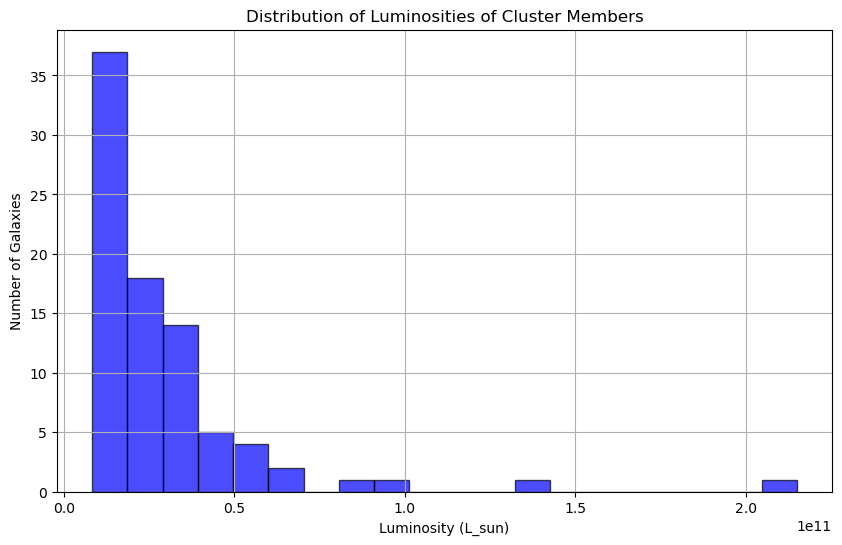

In [11]:
#Step 11

def compute_luminosity(member_galaxies):
    """
    Convert absolute magnitudes of galaxies to luminosities in solar units.

    Parameters:
        member_galaxies (DataFrame): Data containing absolute magnitudes and errors.

    Returns:
        DataFrame: Updated with luminosities and their uncertainties.
    """
    # Absolute magnitude of the Sun in r-band
    M_sun_r = 4.76  

    # Compute luminosity in solar units
    L_solar = 10 ** (0.4 * (M_sun_r - member_galaxies['M_r']))

    # Propagate errors using error propagation formula
    sigma_L = L_solar * (np.log(10) * 0.4 * member_galaxies['M_r_err'])

    # Add results to DataFrame
    member_galaxies['L_r'] = L_solar
    member_galaxies['L_r_err'] = sigma_L

    return member_galaxies

# Compute luminosities for final member galaxies
member_galaxies = compute_luminosity(member_galaxies)

# Print sample results
print(member_galaxies[['M_r', 'M_r_err', 'L_r', 'L_r_err']].head())

plt.figure(figsize=(10, 6))
plt.hist(member_galaxies['L_r'], bins=20, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel("Luminosity (L_sun)")
plt.ylabel("Number of Galaxies")
plt.title("Distribution of Luminosities of Cluster Members")
plt.grid(True)
plt.show()

## Cumulative Luminosity Profile

Total cluster luminosity: 2.45e+12 ± 1.73e+10 L_sun


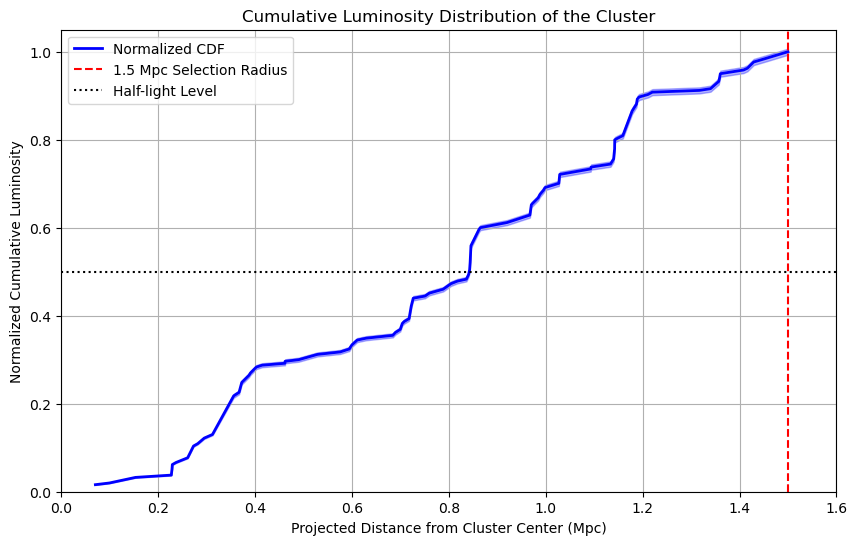

In [12]:
# Step 12

def compute_cumulative_luminosity(member_galaxies):
    """
    Compute the cumulative luminosity of the cluster as a function of radial distance.
    
    Parameters:
        member_galaxies (DataFrame): Contains projected distances and luminosities.
        
    Returns:
        tuple: (sorted distances, normalized cumulative luminosity, normalized error, total luminosity, total luminosity error)
    """
    # Sanity check: Ensure all galaxies are within 1.5 Mpc
    if (member_galaxies['proj_dist'] > 1.5).any():
        raise ValueError("Some galaxies are beyond 1.5 Mpc!")
    
    # Sort galaxies by projected radial distance
    sorted_galaxies = member_galaxies.sort_values(by='proj_dist').reset_index(drop=True)
    
    # Compute cumulative luminosity
    cumulative_luminosity = np.cumsum(sorted_galaxies['L_r']).values
    
    # Total luminosity is the sum of all galaxy luminosities
    total_luminosity = sorted_galaxies['L_r'].sum()
    
    # Calculate uncertainty in total luminosity
    total_luminosity_err = np.sqrt(np.sum(sorted_galaxies['L_r_err']**2))
    
    # Normalize cumulative luminosity by luminosity at 1.5 Mpc
    normalized_cumulative_luminosity = cumulative_luminosity / total_luminosity
    
    # Calculate uncertainty in normalized CDF using error propagation
    cumulative_error = np.sqrt(np.cumsum(sorted_galaxies['L_r_err']**2))
    normalized_error = cumulative_error / total_luminosity
    
    print(f"Total cluster luminosity: {total_luminosity:.2e} ± {total_luminosity_err:.2e} L_sun")
    
    return sorted_galaxies['proj_dist'].values, normalized_cumulative_luminosity, normalized_error, total_luminosity, total_luminosity_err
    
# Compute and plot normalized CDF with uncertainties
radial_distances, normalized_cdf, normalized_err, total_luminosity, total_luminosity_err = compute_cumulative_luminosity(member_galaxies)

plt.figure(figsize=(10, 6))

# Plot the normalized CDF with shaded error region
plt.plot(radial_distances, normalized_cdf, color='blue', linewidth=2, label="Normalized CDF")
plt.fill_between(radial_distances, 
                 normalized_cdf - normalized_err, 
                 normalized_cdf + normalized_err, 
                 alpha=0.3, color='blue')

# Add reference lines
plt.axvline(1.5, color='red', linestyle='dashed', label="1.5 Mpc Selection Radius")
plt.axhline(0.5, color='black', linestyle='dotted', label="Half-light Level")

plt.xlabel("Projected Distance from Cluster Center (Mpc)")
plt.ylabel("Normalized Cumulative Luminosity")
plt.title("Cumulative Luminosity Distribution of the Cluster")
plt.legend()
plt.grid(True)
plt.ylim(0, 1.05)
plt.xlim(0, 1.6)
plt.show()

## Effective Radius Calculation

In [13]:
# Step 13
from scipy.interpolate import interp1d

def compute_effective_radius(radial_distances, normalized_cdf, normalized_err):
    """
    Interpolates the normalized CDF to find R_eff (where CDF = 0.5),
    and computes r_(1/2) using Equation 2. Also calculates uncertainties.

    Parameters:
        radial_distances (array-like): Sorted radial distances of galaxies in Mpc.
        normalized_cdf (array-like): Corresponding cumulative luminosity values.
        normalized_err (array-like): Uncertainty in normalized CDF.

    Returns:
        tuple: (R_eff, r_(1/2), R_eff_err, r_(1/2)_err) in Mpc.
    """
    # Interpolation function for normalized CDF
    cdf_interpolator = interp1d(normalized_cdf, radial_distances, kind='linear', fill_value="extrapolate")

    # Find R_eff (radius where CDF = 0.5)
    R_eff = cdf_interpolator(0.5)

    # Calculate upper and lower bounds for CDF
    cdf_upper = normalized_cdf + normalized_err
    cdf_lower = normalized_cdf - normalized_err

    # Interpolate to find R_eff for upper and lower bounds
    R_eff_upper = cdf_interpolator(0.5 + normalized_err[np.argmin(abs(normalized_cdf - 0.5))])
    R_eff_lower = cdf_interpolator(0.5 - normalized_err[np.argmin(abs(normalized_cdf - 0.5))])

    # Uncertainty in R_eff
    R_eff_err = (R_eff_upper - R_eff_lower) / 2

    # Compute r_(1/2) using Equation 2 and its uncertainty
    r_half = (4 * R_eff) / 3
    r_half_err = (4 * R_eff_err) / 3

    return R_eff, r_half, R_eff_err, r_half_err

R_eff, r_half, R_eff_err, r_half_err = compute_effective_radius(radial_distances, normalized_cdf, normalized_err)

# Print the results
print(f"Effective Radius (R_eff): {R_eff:.3f} ± {R_eff_err:.3f} Mpc")
print(f"Half-light Radius (r_(1/2)): {r_half:.3f} ± {r_half_err:.3f} Mpc")

Effective Radius (R_eff): 0.842 ± 0.001 Mpc
Half-light Radius (r_(1/2)): 1.123 ± 0.001 Mpc


## Velocity Analysis

In [14]:
# Step 14: Compute line-of-sight and peculiar velocities

def compute_velocities(member_galaxies, cluster_z, cluster_z_err):
    """
    Compute the line-of-sight velocities and peculiar velocities of galaxies,
    including uncertainties.

    Parameters:
        member_galaxies (DataFrame): Data containing redshifts and redshift errors of galaxies.
        cluster_z (float): Mean redshift of the cluster.
        cluster_z_err (float): Uncertainty in the cluster's mean redshift.

    Returns:
        DataFrame: Updated with 'v_los', 'v_los_err', 'v_pec', and 'v_pec_err'.
    """
    c = 299792.458  # Speed of light in km/s

    # Compute line-of-sight velocity for each galaxy
    member_galaxies['v_los'] = c * ((1 + member_galaxies['z'])**2 - 1) / ((1 + member_galaxies['z'])**2 + 1)

    # Compute uncertainty in line-of-sight velocity
    partial_v_los = c * (4 * (1 + member_galaxies['z'])) / ((1 + member_galaxies['z'])**2 + 1)**2
    member_galaxies['v_los_err'] = np.abs(partial_v_los) * member_galaxies['zErr']

    # Compute cluster recessional velocity
    v_rec_cluster = c * ((1 + cluster_z)**2 - 1) / ((1 + cluster_z)**2 + 1)

    # Compute uncertainty in cluster recessional velocity
    partial_v_rec = c * (4 * (1 + cluster_z)) / ((1 + cluster_z)**2 + 1)**2
    v_rec_cluster_err = np.abs(partial_v_rec) * cluster_z_err

    # Compute peculiar velocities
    member_galaxies['v_pec'] = member_galaxies['v_los'] - v_rec_cluster

    # Compute uncertainty in peculiar velocity
    member_galaxies['v_pec_err'] = np.sqrt(member_galaxies['v_los_err']**2 + v_rec_cluster_err**2)

    return member_galaxies

# Compute velocities using final cluster redshift and its uncertainty
member_galaxies = compute_velocities(member_galaxies, final_z, final_z_std)

# Print sample results with uncertainties
print(member_galaxies[['z', 'zErr', 'v_los', 'v_los_err', 'v_pec', 'v_pec_err']].head())

          z      zErr         v_los  v_los_err        v_pec   v_pec_err
0  0.082485  0.000013  23711.751465   3.679407  1648.472469  935.782384
1  0.073160  0.000028  21132.609642   7.757182  -930.669353  935.807302
2  0.076726  0.000017  22121.763931   4.600229    58.484936  935.786457
3  0.079812  0.000018  22974.975552   4.979463   911.696556  935.788399
5  0.078172  0.000012  22522.005365   3.372151   458.726369  935.781226


## Velocity Dispersion Measurement

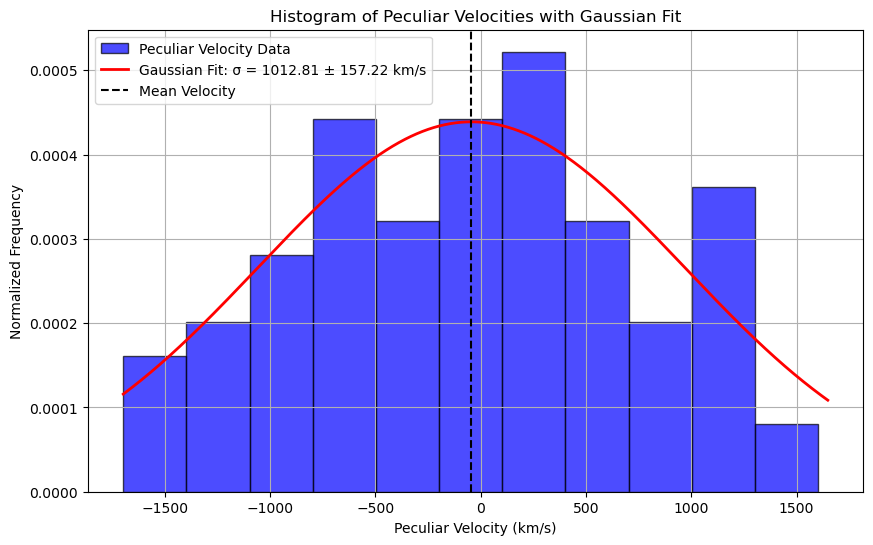

Mean peculiar velocity (μ): -44.26 km/s
Outliers (>3σ): 0
Line-of-sight Velocity Dispersion (σ): 1012.81 ± 157.22 km/s
Biweight Velocity Dispersion: 855.79 km/s
Silverman's test suggests bimodality: False


In [15]:
# Step 15

from astropy.stats import biweight_midvariance
from scipy.stats import gaussian_kde

def gaussian(x, amp, mean, std):
    """Gaussian function for fitting."""
    return amp * np.exp(-0.5 * ((x - mean) / std) ** 2)

def compute_velocity_dispersion(member_galaxies):
    """
    Fit a Gaussian to the peculiar velocity histogram to determine velocity dispersion (σ),
    including uncertainty estimation.
    
    Parameters:
        member_galaxies (DataFrame): Data containing peculiar velocities.

    Returns:
        tuple: (velocity dispersion σ, uncertainty in σ)
    """
    v_pec = member_galaxies['v_pec'].values  # Ensure numpy array

    # Create histogram
    bin_width = 300
    bins = np.arange(v_pec.min(), v_pec.max(), bin_width)
    hist, bin_edges = np.histogram(v_pec, bins=bins, density=True)

    # Compute bin centers
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Fit a Gaussian to the histogram
    popt, pcov = curve_fit(gaussian, bin_centers, hist, p0=[max(hist), np.mean(v_pec), np.std(v_pec)])
    amp, mean_v, std_v = popt
    sigma_v_uncertainty = np.sqrt(np.diag(pcov))[2]

    # Calculate number of outliers (>3σ)
    n_outliers = np.sum(np.abs(v_pec - mean_v) > 3 * std_v)

    # Plot histogram and Gaussian fit
    plt.figure(figsize=(10, 6))
    plt.hist(v_pec, bins=bins, density=True, color='blue', alpha=0.7, 
             edgecolor='black', label="Peculiar Velocity Data")
    
    x_vals = np.linspace(v_pec.min(), v_pec.max(), 1000)
    plt.plot(x_vals, gaussian(x_vals, *popt), color='red', linewidth=2,
             label=f'Gaussian Fit: σ = {std_v:.2f} ± {sigma_v_uncertainty:.2f} km/s')

    # Formatting
    plt.xlabel("Peculiar Velocity (km/s)")
    plt.ylabel("Normalized Frequency")
    plt.title("Histogram of Peculiar Velocities with Gaussian Fit")
    plt.axvline(mean_v, color='black', linestyle='dashed', label="Mean Velocity")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Mean peculiar velocity (μ): {mean_v:.2f} km/s")
    print(f"Outliers (>3σ): {n_outliers}")

    return std_v, sigma_v_uncertainty

# Compute velocity dispersion
sigma_v, sigma_v_uncertainty = compute_velocity_dispersion(member_galaxies)

# Print final result
print(f"Line-of-sight Velocity Dispersion (σ): {sigma_v:.2f} ± {sigma_v_uncertainty:.2f} km/s")

# Compute biweight midvariance for comparison
sigma_v_biweight = np.sqrt(biweight_midvariance(member_galaxies['v_pec']))
print(f"Biweight Velocity Dispersion: {sigma_v_biweight:.2f} km/s")

def silverman_test(data):
    kde = gaussian_kde(data)
    x = np.linspace(min(data), max(data), 1000)
    y = kde(x)
    # Count peaks by finding sign changes in derivative
    dy = np.diff(y)
    peaks = sum((dy[:-1] > 0) & (dy[1:] < 0))
    return peaks > 1  # Returns True if multimodal

is_bimodal = silverman_test(member_galaxies['v_pec'].values)
print(f"Silverman's test suggests bimodality: {is_bimodal}")

## Virial Mass Estimation

In [16]:
# Step 16

def compute_virial_mass(sigma_v, r_half, sigma_v_err, r_half_err):
    """
    Compute the virial mass M_1/2 and its uncertainty using the velocity dispersion and half-mass radius.

    Parameters:
        sigma_v (float): Velocity dispersion in km/s.
        r_half (float): Half-mass radius in Mpc.
        sigma_v_err (float): Uncertainty in velocity dispersion in km/s.
        r_half_err (float): Uncertainty in half-mass radius in Mpc.

    Returns:
        tuple: (Virial mass M_1/2 in solar masses, Uncertainty in M_1/2 in solar masses)
    """
    G = 6.674e-11  # Gravitational constant in m³/kg/s²
    sigma_v_mks = sigma_v * 1000  # Convert km/s to m/s
    r_half_mks = r_half * 3.086e22  # Convert Mpc to meters

    # Compute virial mass in kg
    virial_mass_kg = (3 * sigma_v_mks**2 * r_half_mks) / G

    # Convert kg to solar masses (1 solar mass = 1.989 × 10^30 kg)
    virial_mass_solar = virial_mass_kg / (1.989e30)

    # Compute relative uncertainties
    rel_sigma_v_err = sigma_v_err / sigma_v
    rel_r_half_err = r_half_err / r_half

    # Compute uncertainty in virial mass
    rel_virial_mass_err = np.sqrt((2 * rel_sigma_v_err)**2 + rel_r_half_err**2)
    virial_mass_solar_err = virial_mass_solar * rel_virial_mass_err

    return virial_mass_solar, virial_mass_solar_err

# Compute M_1/2 and its uncertainty
M_half, M_half_err = compute_virial_mass(sigma_v, r_half, sigma_v_uncertainty, r_half_err)

# Print result
print(f"Virial Mass (M_1/2): {M_half:.3e} ± {M_half_err:.3e} M_sun")

Virial Mass (M_1/2): 8.031e+14 ± 2.493e+14 M_sun


## Luminosity Within Half-Mass Radius

In [17]:
# Step 17

def compute_luminosity_within_r_half(r_half, radial_distances, normalized_cdf, luminosity_at_1p5, r_half_err, luminosity_at_1p5_err):
    """
    Interpolate the normalized CDF of luminosity at r_half to compute L_1/2 and its uncertainty.

    Parameters:
        r_half (float): Half-mass radius in Mpc.
        radial_distances (array-like): Array of radial distances where CDF is computed.
        normalized_cdf (array-like): Normalized cumulative luminosity values (0 to 1).
        luminosity_at_1p5 (float): Total luminosity at 1.5 Mpc.
        r_half_err (float): Uncertainty in half-mass radius in Mpc.
        luminosity_at_1p5_err (float): Uncertainty in total luminosity at 1.5 Mpc.

    Returns:
        tuple: (L_1/2, uncertainty in L_1/2) in solar luminosities.
    """
    # Interpolation function for normalized CDF
    cdf_interp = interp1d(radial_distances, normalized_cdf, kind='linear', fill_value='extrapolate')

    # Get normalized luminosity fraction at r_half
    f_L_half = cdf_interp(r_half)

    # Compute total luminosity within r_half
    L_half = f_L_half * luminosity_at_1p5

    # Estimate uncertainty in f_L_half due to uncertainty in r_half
    # Use finite difference to approximate the derivative of the CDF at r_half
    delta_r = 0.01 * r_half  # Small perturbation to estimate derivative
    f_L_half_upper = cdf_interp(r_half + delta_r)
    f_L_half_lower = cdf_interp(r_half - delta_r)
    df_L_dr = (f_L_half_upper - f_L_half_lower) / (2 * delta_r)

    # Uncertainty in f_L_half due to uncertainty in r_half
    f_L_half_err = np.abs(df_L_dr) * r_half_err

    # Compute relative uncertainties
    rel_f_L_half_err = f_L_half_err / f_L_half
    rel_luminosity_at_1p5_err = luminosity_at_1p5_err / luminosity_at_1p5

    # Compute uncertainty in L_half
    rel_L_half_err = np.sqrt(rel_f_L_half_err**2 + rel_luminosity_at_1p5_err**2)
    L_half_err = L_half * rel_L_half_err

    return L_half, L_half_err

# Compute L_1/2 and its uncertainty
L_half, L_half_err = compute_luminosity_within_r_half(r_half, radial_distances, normalized_cdf, total_luminosity, r_half_err, total_luminosity_err)

# Print result
print(f"Total Luminosity within r_1/2 (L_1/2): {L_half:.3e} ± {L_half_err:.3e} L_sun")

Total Luminosity within r_1/2 (L_1/2): 1.820e+12 ± 1.288e+10 L_sun


## Mass-to-Light Ratio Calculation

In [18]:
# Step 18

def compute_mass_to_light_ratio(M_half, L_half, M_half_err, L_half_err):
    """
    Compute the mass-to-light ratio (M/L) of the cluster and its uncertainty.

    Parameters:
        M_half (float): Virial mass within r_1/2 (in solar masses).
        L_half (float): Total luminosity within r_1/2 (in solar luminosities).
        M_half_err (float): Uncertainty in virial mass (in solar masses).
        L_half_err (float): Uncertainty in total luminosity (in solar luminosities).

    Returns:
        tuple: (Mass-to-light ratio (M/L), uncertainty in M/L) in solar units.
    """
    # Compute mass-to-light ratio
    M_L_ratio = M_half / L_half

    # Compute relative uncertainties
    rel_M_half_err = M_half_err / M_half
    rel_L_half_err = L_half_err / L_half

    # Compute uncertainty in M/L ratio
    rel_M_L_ratio_err = np.sqrt(rel_M_half_err**2 + rel_L_half_err**2)
    M_L_ratio_err = M_L_ratio * rel_M_L_ratio_err

    return M_L_ratio, M_L_ratio_err

# Compute M/L ratio and its uncertainty
M_L_ratio, M_L_ratio_err = compute_mass_to_light_ratio(M_half, L_half, M_half_err, L_half_err)

# Print result
print(f"Mass-to-Light Ratio (M/L): {M_L_ratio:.2f} ± {M_L_ratio_err:.2f} M_sun/L_sun")

Mass-to-Light Ratio (M/L): 441.18 ± 137.01 M_sun/L_sun


## Summary

Key results:
- Virial Mass: (8.03 ± 2.49) × 10¹⁴ M☉
- Mass-to-Light Ratio: 441 ± 137 M☉/L☉
- The extremely high M/L ratio provides strong evidence for dark matter dominance in ACO 2670